In [105]:
import numpy as np
import pandas as pd
import torch
import re
from Constants import *
import simplejson
from Preprocessing import *
from Utils import *
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,accuracy_score


In [106]:
decision_model,transition_model1,transition_model2, outcome_model = load_models()
transition_model1

TransitionEnsemble(
  (base_models): ModuleList(
    (0-3): 4 x OutcomeSimulator(
      (input_dropout): Dropout(p=0.1, inplace=False)
      (layers): ModuleList(
        (0): Linear(in_features=56, out_features=400, bias=True)
        (1): ReLU()
        (2): Linear(in_features=400, out_features=400, bias=True)
        (3): ReLU()
      )
      (batchnorm): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.9, inplace=False)
      (relu): Softplus(beta=1, threshold=20)
      (sigmoid): Sigmoid()
      (softmax): LogSoftmax(dim=1)
      (disease_layer): Linear(in_features=400, out_features=3, bias=True)
      (nodal_disease_layer): Linear(in_features=400, out_features=3, bias=True)
      (dlt_layers): ModuleList(
        (0-7): 8 x Linear(in_features=400, out_features=1, bias=True)
      )
      (treatment_layer): Linear(in_features=400, out_features=7, bias=True)
    )
    (4-7): 4 x OutcomeSimulator(
      (input_dropout): Dr

In [107]:

def transition_sample(state):
    ids = get_dt_ids()
    
    train_ids, test_ids = get_tt_split()
    
    dataset = DTDataset()
    
    #only train on people with  IC for state 1 since other people can't have any outcomes otherwise
    require = None
    if state == 1:
        require = Const.decisions[0] #we don't expect a state update if there is no treatment
        valid_ids = dataset.get_input_state(require=require).index.values
        train_ids = [t for t in train_ids if t in valid_ids]
        test_ids = [t for t in test_ids if t in valid_ids]
    xtrain = dataset.get_input_state(step=state,ids=train_ids,require=require)
    xtest = dataset.get_input_state(step=state,ids=test_ids,require=require)
    ytrain = dataset.get_intermediate_outcomes(step=state,ids=train_ids,require=require)
    ytest = dataset.get_intermediate_outcomes(step=state,ids=test_ids,require=require)

    xtrain = df_to_torch(xtrain)
    xtest = df_to_torch(xtest)
    ytrain = [df_to_torch(t) for t in ytrain]
    ytest= [df_to_torch(t) for t in ytest]
    return xtrain,xtest,ytrain,ytest

transition_sample(0)[-1]

/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


[tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
         1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
         1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
         1., 1.]),
 tensor([0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
         

In [108]:
from sklearn.metrics import precision_recall_fscore_support
def mc_metrics(yt,yp,numpy=False,is_dlt=False):
    if not numpy:
        yt = yt.cpu().detach().numpy()
        yp = yp.cpu().detach().numpy()
    #dlt prediction (binary)
    if is_dlt:
        acc = accuracy_score(yt,yp>.5)
        if yt.sum() > 1:
            auc = roc_auc_score(yt,yp)
        else:
            auc=-1
        error = np.mean((yt-yp)**2)
        return {'accuracy': acc, 'mse': error, 'auc': auc}
    #this is a catch for when I se the dlt prediction format (encoded integer ordinal, predict as a categorical and take the argmax)
    elif yt.ndim > 1:
        try:
            bacc = balanced_accuracy_score(yt.argmax(axis=1),yp.argmax(axis=1))
        except:
            bacc = -1
        try:
            roc_micro = roc_auc_score(yt,yp,average='micro')
        except:
            roc_micro=-1
        try:
            roc_macro = roc_auc_score(yt,yp,average='macro')
        except Exception as e:
            try: 
                roc_macro = roc_auc_score(yt[:,0:2],yp[:,0:2],average='macro')
            except:
                roc_macro = -1
        try:
            roc_weighted = roc_auc_score(yt,yp,average='weighted')
        except:
            try:
                roc_weighted = roc_auc_score(yt[:,0:2],yp[:,0:2],average='weighted')
            except:
                roc_weighted= -1
        return {'accuracy': bacc, 'auc_micro': roc_micro,'auc_mean': roc_macro,'auc_weighted': roc_weighted}
    #outcomes (binary)
    else:
        multiclass = yp.ndim > 1
        if multiclass:
            yp = yp.argmax(axis=1)
        try:
            if not multiclass:
                bacc = accuracy_score(yt,(yp>.5).astype(int))
            else:
                bacc = accuracy_score(yt,yp)
        except Exception as e:
            print(e,yp,yt)
            bacc = -1
        try:
            roc = roc_auc_score(yt,yp)
        except:
            roc = -1
        try:
            if not multiclass:
                pr,re,fscore,supp = precision_recall_fscore_support(yt,(yp>.5).astype(int),average='binary')
            else:
                pr,re,fscore,supp = precision_recall_fscore_support(yt,yp,average='macro')
        except Exception as e:
            print(e)
            [pr,re,fscore,supp] = [-1,-1,-1,-1]
        error = np.mean((yt-yp)**2)
        return {'accuracy': bacc, 'mse': error, 'auc': roc,'precision': pr,'recall':re,'f1':fscore}

def state_metrics(ytrue,ypred,numpy=False):
    pd_metrics = mc_metrics(ytrue[0],ypred[0],numpy=numpy)
    nd_metrics = mc_metrics(ytrue[1],ypred[1],numpy=numpy)
    mod_metrics = mc_metrics(ytrue[1],ypred[1],numpy=numpy)
    
    dlt_metrics = []
    dlt_true = ytrue[3]
    dlt_pred = ypred[3]
    ndlt = dlt_true.shape[1]
    nloss = torch.nn.NLLLoss()
    for i in range(ndlt):
        dm = mc_metrics(dlt_true[:,i],dlt_pred[:,i].view(-1),is_dlt=True)
        dlt_metrics.append(dm)
    dlt_acc =[d['accuracy'] for d in dlt_metrics]
    dlt_error = [d['mse'] for d in dlt_metrics]
    dlt_auc = [d['auc'] for d in dlt_metrics]
    
    acc_mean = np.mean([a for a in dlt_acc if a >= 0 and a < 1])
    auc_mean = np.mean([a for a in dlt_auc if a >= 0])
    results = {'pd': pd_metrics,'nd': nd_metrics,'mod': mod_metrics,
               'dlts': {'accuracy': dlt_acc,'accuracy_mean': acc_mean,'auc': dlt_auc,'auc_mean': auc_mean}
              }
    return results
def outcome_metrics(ytrue,ypred,numpy=False):
    res = {}
    for i, outcome in enumerate(Const.outcomes):
        metrics = mc_metrics(ytrue[i],ypred[:,i])
        res[outcome] = metrics
    return res

def evaluate_transition_model(model,state,ensemble=True):
    [xtrain,xtest, ytrain,ytest] = transition_sample(state)
    xtest = xtest.to(model.get_device())
    ytest = [yy.to(model.get_device()) for yy in ytest]
    if ensemble:
        ypred = model(xtest)['predictions']
    else:
        ypred = model(xtest)
    if state < 3:
        metrics = state_metrics(ytest,ypred)
    else:
        metrics = outcome_metrics(ytest,ypred)
    return metrics

def format_main_result(res,as_df=True):
    newres = {}
    for key,value in res.items():
        if key != 'dlts':
            entry = {}
            for key2, value2 in value.items():
                if value2 > -1 and value2 < 1:
                    entry[key2] = value2
            newres[key] = entry
        else:
            for i,dltname in enumerate(Const.dlt1):
                entry = {}
                name = 'DLT-'+dltname
                for key2, value2 in value.items():
                    if type(value2) != type([]): 
                        continue
                    name2 = key2 if key2 != 'auc' else 'auc_mean'
                    newval = value2[i]
                    if newval > -1 and newval < 1:
                        entry[name2] = newval
                newres[name] = entry
    if as_df:
        df = pd.DataFrame(newres).T
        df = df.dropna(axis=0,how='all',subset = [c for c in df.columns if 'auc' in c])
        return df.reindex(sorted(df.columns), axis=1)
    return newres

def aggregate_evaluations(res_list):
    medians = {}
    means = {}
    lower = {}
    upper = {}
    nitems = len(res_list)
    for key, entry in res_list[0].items():
        if key != 'dlts':
            mean_entry = {}
            median_entry = {}
            lentry = {}
            uentry = {}
            for key2,vv in entry.items():
                values = [r[key][key2] for r in res_list]
                values = [v for v in values if v >= 0 and v < 1]
                val_mean = np.mean(values)
                val_median = np.median(values)
                val_cf = np.quantile(values,[.05,.95]) if len(values) > 1 else [np.NaN,np.NaN]
                lentry[key2] = val_cf[0]
                uentry[key2] = val_cf[1]
                mean_entry[key2] = val_mean
                median_entry[key2] = val_median
                medians[key] = median_entry
                means[key] = mean_entry
                lower[key] = lentry
                upper[key] = uentry
        else:
            for i,dltname in enumerate(Const.dlt1):
                mean_entry = {}
                median_entry = {}
                lentry = {}
                uentry = {}
                name = 'DLT-'+dltname
                for key2,vv in entry.items():
                    if type(vv) != type([]):
                        continue
                    values = [r[key][key2][i] for r in res_list]
                    values = [v for v in values if v >= 0 and v < 1]
                    val_mean = np.mean(values)
                    val_median = np.median(values)
                    val_cf = np.quantile(values,[.05,.95]) if len(values) > 1 else [np.NaN,np.NaN]
                    name2 = key2 if key2 != 'auc' else 'auc_mean'
                    mean_entry[name2] = val_mean
                    median_entry[name2] = val_median
                    lentry[name2] = val_cf[0]
                    uentry[name2] = val_cf[1]
                    medians[name] = median_entry
                    means[name] = mean_entry
                    lower[name] = lentry
                    upper[name] = uentry
    suffixes = ['mean','median','5%','95%']
    dfs = []
    for suffix,data in zip(suffixes,[means,medians,lower,upper]):
        newdf = pd.DataFrame(data).T
        newdf.columns = [c+'-'+suffix for c in newdf.columns]
        dfs.append(newdf)
    #drop anything without and valid aucs isnce htats a bad class
    df= pd.concat(dfs,axis=1).dropna(axis=0,how='all',subset = [c for c in dfs[0].columns if 'auc' in c])
    return df.reindex(sorted(df.columns), axis=1)

def evaluate_ensemble(emodel,state):
    overall_res = evaluate_transition_model(emodel,state,True)
    model_res = [evaluate_transition_model(m,state,False) for m in emodel.base_models]
    error_model_res = [evaluate_transition_model(m,state,False) for m in emodel.error_models]
    return overall_res, model_res,error_model_res


In [109]:
def aggregate_ensemble_results(ores,mres,eres,concat=False):
    res = [format_main_result(ores), aggregate_evaluations(mres),aggregate_evaluations(eres)]
    if concat:
        return pd.concat(res,axis=1)
    return res
# aggregate_ensemble_results(*results1,concat=True)

/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option

/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype o

/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype o

/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype o

/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype o

/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype o

/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype o

/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:252: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/data/DigitalTwinVis/python/Preprocessing.py:192: DtypeWarning: Columns (55) have mixed types. Specify dtype o

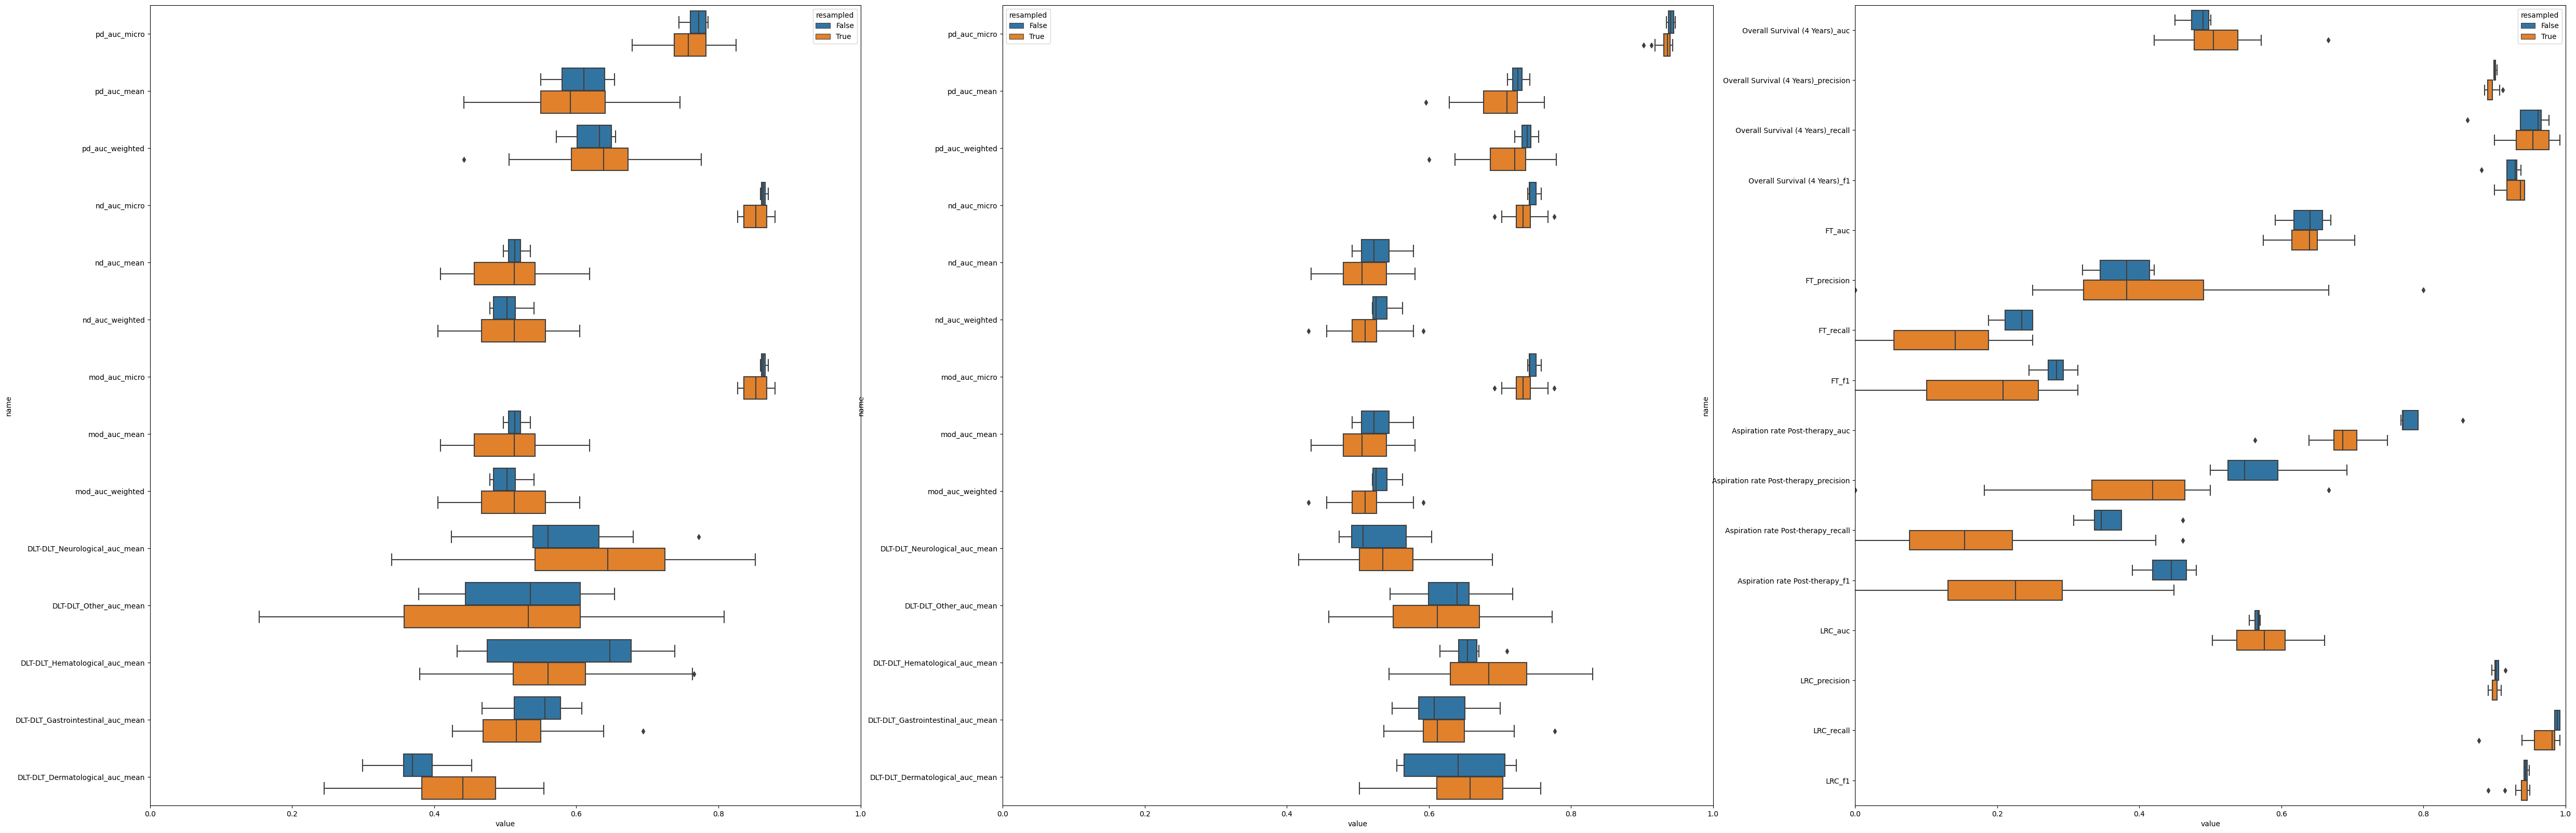

In [110]:
def unravel_result(res):
    res = format_main_result(res,as_df=False)
    r2 = {}
    for key,value in res.items():
        for key2, value2 in value.items():
            r2[key+'_'+key2] = value2
    return r2

import seaborn as sns
import matplotlib.pyplot as plt
def vis_ensemble_results(resultlist,ax=None):
    plotstuff = []
    for r in resultlist[1]:
        rr = unravel_result(r)
        for k,v in rr.items():
            entry = {'name': k,'value': v,'resampled': False}
            plotstuff.append(entry)
    for r in resultlist[-1]:
        rr = unravel_result(r)
        for k,v in rr.items():
            entry = {'name': k,'value': v,'resampled': True}
            plotstuff.append(entry)
    plotstuff = [v for v in plotstuff if 'accuracy' not in v['name'] and 'mse' not in v['name']]
    tempdf = pd.DataFrame(plotstuff)
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(10,10))
    sns.boxplot(
        data=tempdf,
        orient='h',
        hue='resampled',
        x='value',
        y='name',
        ax=ax,
    )
    ax.set_xlim(,1)

fig,axes = plt.subplots(1,3,figsize=(60,20))
for i,model in enumerate([transition_model1,transition_model2,outcome_model]):
    results = evaluate_ensemble(model,i+1)
    vis_ensemble_results(results,ax=axes[i])

In [ ]:
def evaluate_decision_model()